- [ ] Try to overfit earlier
    * Try adding more layers

In [24]:
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
from scipy import signal
from tqdm import tqdm

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

import random

%matplotlib inline

## Load data

In [25]:
data_path = "Data/GeneratedData/combined_data/"
base_path = os.getcwd()

# REST
# IDD = np.load(os.path.join(data_path, "IDD_rest.npy"))
# TDC = np.load(os.path.join(data_path, "TDC_rest.npy"))

# MUSIC
# IDD = np.load(os.path.join(data_path, "IDD_music.npy"))
# TDC = np.load(os.path.join(data_path, "TDC_music.npy"))

X_scalogram = np.load("Data/GeneratedData/X_scalogram_music.npy")
Y = [0]*(len(X_scalogram)//2) + [1]*(len(X_scalogram)//2)
Y = np.asarray(Y)

In [26]:
print(X_scalogram.shape)
print(Y.shape)

(8470, 448, 128)
(8470,)


## Create Spectrograms

In [27]:
# Modified scalogram function from Fusion notebook
def scalogram(x, Hz, hz, num_secs, w = 5.):
    ''' x = time series
        Hz = sampling rate in Hz of the input signal
        hz = desired sampling rate (by downsampling)
        start_sec = starting second in x
        num_secs = total number of seconds of our clip
        w = width parameter
        log =raw_seiz if true take log of spectrum values
    '''
    
    downsample = int(round(Hz / hz))
    X = x[0: num_secs * Hz : downsample]


    t, dt = np.linspace(0, num_secs, hz * num_secs, retstep = True)
    fs = 1 / dt

    freq = np.linspace(1, fs / 2, int(hz / 2))
    widths = w * fs / (2 * np.pi * freq)

    cwtm = signal.cwt(X,
                      signal.morlet2,
                      widths,
                      w = w)
    
    return cwtm.real.astype("float64")

In [28]:
def generate_scalogram(data, Hz, hz, num_secs, w = 5.):
    scalogram_data = np.zeros((data.shape[0], data.shape[1] * (hz // 2), hz * num_secs), dtype="float64")
    for sample_index in tqdm(range(data.shape[0])):
        for channel_index in range(0, data.shape[1]):
            scalogram_data[sample_index][channel_index * (hz//2): channel_index * (hz//2) + hz//2] = \
            scalogram(data[sample_index][channel_index], 128, 64, 2)
    return scalogram_data

In [29]:
# X_scalogram = generate_scalogram(X, 128, 64, 2)

In [30]:
X_scalogram.shape

(8470, 448, 128)

In [31]:
def plot_scalograms(data, sample_index, N=128, hz=64, T=2, ts=0, w=4.):
    """
    :param N: signal sampling rate
    :param hz: downsampled sampling rate
    :param T: seconds
    :param ts: starting second
    :param w: 
    """

    t, dt = np.linspace(ts, ts + T, hz * T, retstep = True)
    fs = 1 / dt

    freq = np.linspace(1, (14 * (fs / 2)), (14 * int(hz / 2)))
    
    print("Y label:", Y[sample_index])
    
    plt.rcParams['figure.figsize'] = 14, 30
    im = plt.pcolormesh(t, freq, np.abs(data[sample_index]), cmap = 'jet') # 'viridis'
    plt.show()


Y label: 0


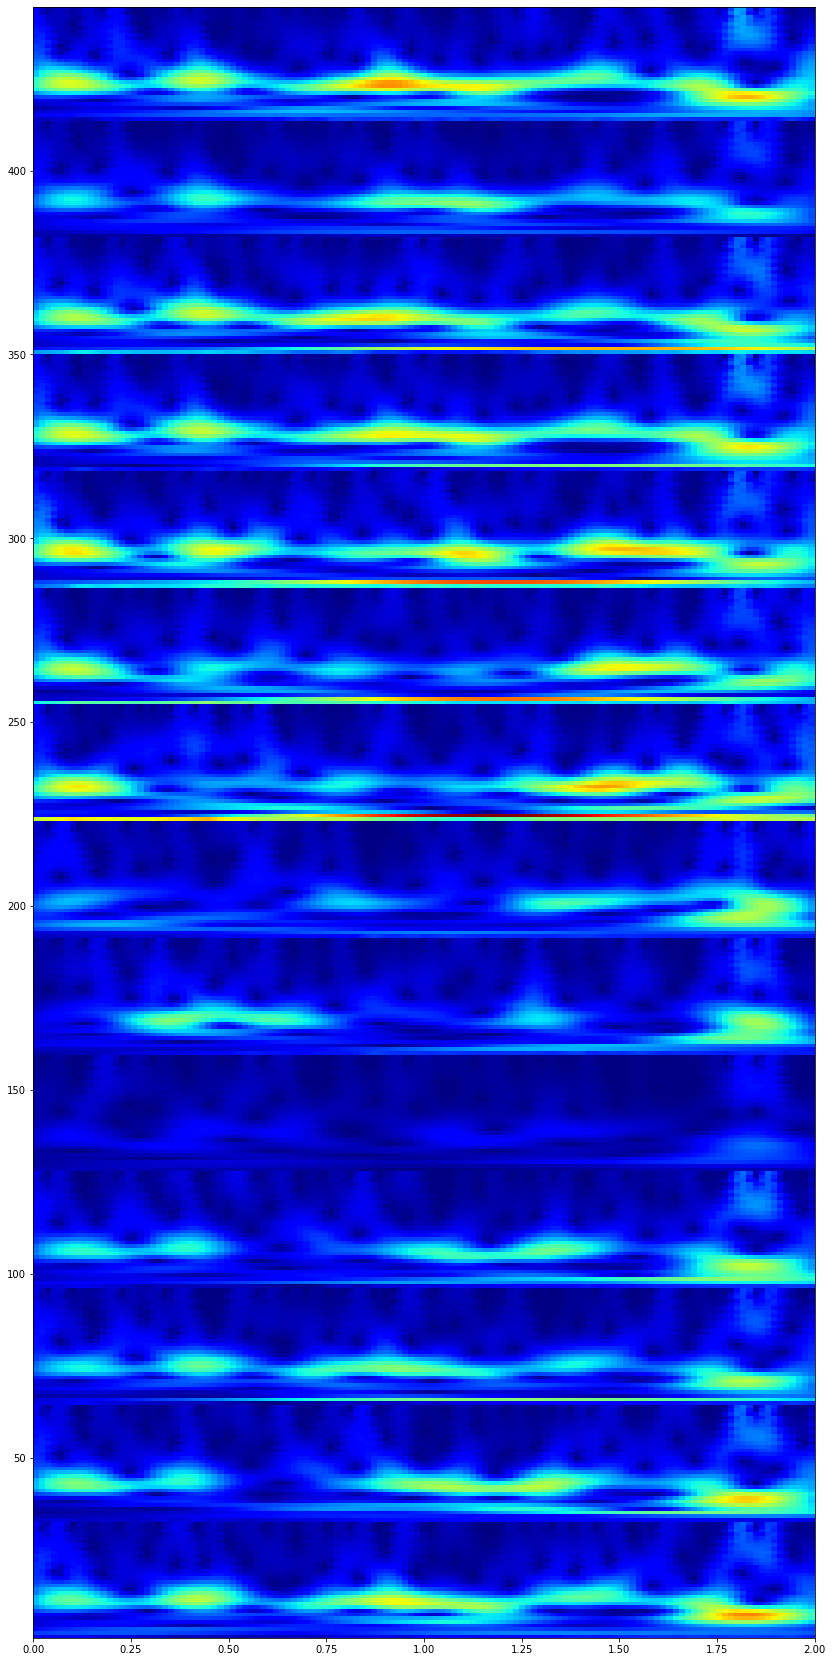

In [32]:
plot_scalograms(X_scalogram, 2000)

In [33]:
# reshape data
X_scalogram_shaped = X_scalogram.reshape(14, X_scalogram.shape[0]//14, X_scalogram.shape[1] * X_scalogram.shape[2])
Y_shaped = Y.reshape(14, Y.shape[0]//14)
print("X_scalogram shape: ", X_scalogram_shaped.shape)
print("Y shape", Y_shaped.shape)

X_scalogram shape:  (14, 605, 57344)
Y shape (14, 605)


In [34]:
# import copy
# x2 = copy.deepcopy(X_scalogram_shaped)
# x2 = x2.reshape((14, 605, 57344))
# print(x2.shape)
# x2 = x2.reshape((8470, 57344))
# np.array_equiv(x2, X_scalogram_shaped)

## KFold Cross Validation

In [35]:
# def generate_splits(num_folds=3, num_subjects=14, train_size=10):
#     train_size //= 2  # divide by 2 since we want to split with idd and tdc separately
#     for _ in range(num_folds):
#         tdc_indices = random.sample(range(num_subjects//2), num_subjects//2)
#         idd_indices = random.sample(range(num_subjects//2, num_subjects), num_subjects//2)
        
#         print("tdc indices:", tdc_indices)
#         print("idd indices:", idd_indices)
        
#         train_indices = tdc_indices[:train_size] + idd_indices[:train_size]
#         val_indices = tdc_indices[train_size:] + idd_indices[train_size:]
        
#         yield train_indices, val_indices
        
# for t, v in generate_splits():
#     print(t, v)

In [36]:
def generate_splits():
    # [0, 1, 2, 3,  4,  5,  6]
    # [7, 8, 9, 10, 11, 12, 13]
    train_indices = [[2,3,4,5,6,9,10,11,12,13], [0,1,4,5,6,7,8,11,12,13], [0,1,2,3,6,7,8,9,10,13]]
    val_indices = [[0,1,7,8], [2,3,9,10], [4,5,11,12]]
    
    for ti, vi in zip(train_indices, val_indices):
        yield ti, vi
        
# for t, v in generate_splits():
#     print(t, v)

## 1-Layer FCNN

In [37]:
# 1-layer
fold_count = 1
acc_per_fold = []
loss_per_fold = []

for train_indices, val_indices in generate_splits():
    print('-------------------------------------------------------------------------------------------')
    
    # Define model
    model1 = keras.Sequential([
        keras.layers.Dense(1, input_dim=(57344), activation=tf.nn.sigmoid)
    ])
    
    # Compile Model
    model1.compile(
      optimizer='adam',
      loss='binary_crossentropy',
      metrics=['accuracy'],
    )
    
#     print(model1.summary())
    
    print(f'Training for fold {fold_count} ...')
    # Train model
    history = model1.fit(X_scalogram_shaped[train_indices].reshape((-1, 57344)), 
                    Y_shaped[train_indices].reshape(-1), 
                    epochs=10, 
                    batch_size=256, 
                    verbose=1)
    
    # Generate generalization metrics
    scores = model1.evaluate(X_scalogram_shaped[val_indices].reshape((-1, 57344)), 
                             Y_shaped[val_indices].reshape(-1), 
                             verbose=0)
    print(f'Score for fold {fold_count}: {model1.metrics_names[0]} of {scores[0]}; {model1.metrics_names[1]} of {scores[1]*100}%')
    acc_per_fold.append(scores[1] * 100)
    loss_per_fold.append(scores[0])
    fold_count += 1
    tf.keras.backend.clear_session()

-------------------------------------------------------------------------------------------
Training for fold 1 ...
Train on 6050 samples
Epoch 1/10
6050/6050 [==============================] - 24s 4ms/sample - loss: 11.7778 - accuracy: 0.4866
Epoch 2/10
6050/6050 [==============================] - 7s 1ms/sample - loss: 9.8486 - accuracy: 0.5509
Epoch 3/10
6050/6050 [==============================] - 2s 353us/sample - loss: 8.7280 - accuracy: 0.5707
Epoch 4/10
6050/6050 [==============================] - 1s 240us/sample - loss: 8.2258 - accuracy: 0.5694
Epoch 5/10
6050/6050 [==============================] - 1s 239us/sample - loss: 7.4893 - accuracy: 0.5747
Epoch 6/10
6050/6050 [==============================] - 1s 236us/sample - loss: 8.5245 - accuracy: 0.5769
Epoch 7/10
6050/6050 [==============================] - 2s 258us/sample - loss: 8.8146 - accuracy: 0.5783
Epoch 8/10
6050/6050 [==============================] - 1s 246us/sample - loss: 8.6250 - accuracy: 0.5780
Epoch 9/10
6050/

In [38]:
# summary
print('------------------------------------------------------------------------')
print('Score per fold')
for i in range(0, len(acc_per_fold)):
    print('------------------------------------------------------------------------')
    print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} - Accuracy: {acc_per_fold[i]}%')
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
print(f'> Loss: {np.mean(loss_per_fold)}')
print('------------------------------------------------------------------------')

------------------------------------------------------------------------
Score per fold
------------------------------------------------------------------------
> Fold 1 - Loss: 9.085463150276626 - Accuracy: 51.98346972465515%
------------------------------------------------------------------------
> Fold 2 - Loss: 13.781319920878765 - Accuracy: 50.247931480407715%
------------------------------------------------------------------------
> Fold 3 - Loss: 14.849956878157686 - Accuracy: 48.88429641723633%
------------------------------------------------------------------------
Average scores for all folds:
> Accuracy: 50.37189920743307 (+- 1.2682651655870196)
> Loss: 12.572246649771024
------------------------------------------------------------------------


## 3-Layer FCNN

In [39]:
# 1-layer
fold_count = 1
acc_per_fold = []
loss_per_fold = []

for train_indices, val_indices in generate_splits():
    print('-------------------------------------------------------------------------------------------')
    
    # Define Model
    model2 = keras.Sequential([
        keras.layers.Dense(8, input_dim=(57344), activation=tf.nn.relu), 
        keras.layers.Dense(4, activation=tf.nn.relu), 
        keras.layers.Dense(1, activation=tf.nn.sigmoid)
    ])
    
    # Compile Model
    model2.compile(
      optimizer='adam',
      loss='binary_crossentropy',
      metrics=['accuracy'],
    )
#     model2.summary()
    
    print(f'Training for fold {fold_count} ...')
    # Train model
    history = model2.fit(X_scalogram_shaped[train_indices].reshape((-1, 57344)), 
                        Y_shaped[train_indices].reshape(-1), 
                        epochs=20, 
                        batch_size=256,
                        verbose=1)
    
    # Generate generalization metrics
    scores = model2.evaluate(X_scalogram_shaped[val_indices].reshape((-1, 57344)), 
                             Y_shaped[val_indices].reshape(-1),
                             verbose=0)
    print(f'Score for fold {fold_count}: {model2.metrics_names[0]} of {scores[0]}; {model2.metrics_names[1]} of {scores[1]*100}%')
    acc_per_fold.append(scores[1] * 100)
    loss_per_fold.append(scores[0])
    fold_count += 1
    tf.keras.backend.clear_session()

-------------------------------------------------------------------------------------------
Training for fold 1 ...
Train on 6050 samples
Epoch 1/20
6050/6050 [==============================] - 19s 3ms/sample - loss: 8.1350 - accuracy: 0.6428
Epoch 2/20
6050/6050 [==============================] - 8s 1ms/sample - loss: 3.0820 - accuracy: 0.7782
Epoch 3/20
6050/6050 [==============================] - 3s 425us/sample - loss: 1.3745 - accuracy: 0.8345
Epoch 4/20
6050/6050 [==============================] - 2s 320us/sample - loss: 0.9337 - accuracy: 0.8514
Epoch 5/20
6050/6050 [==============================] - 2s 318us/sample - loss: 0.6055 - accuracy: 0.8691
Epoch 6/20
6050/6050 [==============================] - 2s 326us/sample - loss: 0.5411 - accuracy: 0.8820
Epoch 7/20
6050/6050 [==============================] - 2s 316us/sample - loss: 0.4639 - accuracy: 0.8851
Epoch 8/20
6050/6050 [==============================] - 2s 379us/sample - loss: 0.4988 - accuracy: 0.8860
Epoch 9/20
6050/6

In [40]:
# summary
print('------------------------------------------------------------------------')
print('Score per fold')
for i in range(0, len(acc_per_fold)):
    print('------------------------------------------------------------------------')
    print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} - Accuracy: {acc_per_fold[i]}%')
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
print(f'> Loss: {np.mean(loss_per_fold)}')
print('------------------------------------------------------------------------')

------------------------------------------------------------------------
Score per fold
------------------------------------------------------------------------
> Fold 1 - Loss: 6.0922508572743945 - Accuracy: 77.3553729057312%
------------------------------------------------------------------------
> Fold 2 - Loss: 1.5041325066700455 - Accuracy: 77.97520756721497%
------------------------------------------------------------------------
> Fold 3 - Loss: 14.786284964537817 - Accuracy: 67.8925633430481%
------------------------------------------------------------------------
Average scores for all folds:
> Accuracy: 74.40771460533142 (+- 4.6138520226031075)
> Loss: 7.460889442827419
------------------------------------------------------------------------


## Rest

------------------------------------------------------------------------
### 1-Layer

------------------------------------------------------------------------
> Fold 1 - Loss: 14.628281607509644 - Accuracy: 49.793389439582825%
------------------------------------------------------------------------
> Fold 2 - Loss: 18.85972856411264 - Accuracy: 46.36363685131073%
------------------------------------------------------------------------
> Fold 3 - Loss: 23.017300266864872 - Accuracy: 45.9090918302536%
------------------------------------------------------------------------
Average scores for all folds:
> Accuracy: 47.35537270704905 (+- 1.73389676454087)
> Loss: 18.835103479495718
------------------------------------------------------------------------

### 3-Layer

------------------------------------------------------------------------
> Fold 1 - Loss: 2.4758452466696745 - Accuracy: 67.1074390411377%
------------------------------------------------------------------------
> Fold 2 - Loss: 4.869585390943141 - Accuracy: 64.29752111434937%
------------------------------------------------------------------------
> Fold 3 - Loss: 7.506062624474202 - Accuracy: 75.86776614189148%
------------------------------------------------------------------------
Average scores for all folds:
> Accuracy: 69.09090876579285 (+- 4.927356059849842)
> Loss: 4.950497754029006
------------------------------------------------------------------------

## Music
------------------------------------------------------------------------
### 1-Layer

------------------------------------------------------------------------
> Fold 1 - Loss: 9.085463150276626 - Accuracy: 51.98346972465515%
------------------------------------------------------------------------
> Fold 2 - Loss: 13.781319920878765 - Accuracy: 50.247931480407715%
------------------------------------------------------------------------
> Fold 3 - Loss: 14.849956878157686 - Accuracy: 48.88429641723633%
------------------------------------------------------------------------
Average scores for all folds:
> Accuracy: 50.37189920743307 (+- 1.2682651655870196)
> Loss: 12.572246649771024

------------------------------------------------------------------------
### 3-Layer

------------------------------------------------------------------------
> Fold 1 - Loss: 6.0922508572743945 - Accuracy: 77.3553729057312%
------------------------------------------------------------------------
> Fold 2 - Loss: 1.5041325066700455 - Accuracy: 77.97520756721497%
------------------------------------------------------------------------
> Fold 3 - Loss: 14.786284964537817 - Accuracy: 67.8925633430481%
------------------------------------------------------------------------
Average scores for all folds:
> Accuracy: 74.40771460533142 (+- 4.6138520226031075)
> Loss: 7.460889442827419
------------------------------------------------------------------------

---
# OLD CODE
---

## Test-Train split

In [19]:
# X_train, X_val, y_train, y_val = train_test_split(X_scalogram_shaped, Y, test_size=0.2, stratify=Y, random_state=42)

In [12]:
# # 10/4 split
# X_train = np.concatenate((X_scalogram_shaped[:3025], X_scalogram_shaped[4235:7260]))
# y_train = np.concatenate((Y[:3025], Y[4235:7260]))

# X_val = np.concatenate((X_scalogram_shaped[3025:4235], X_scalogram_shaped[7260:]))
# y_val = np.concatenate((Y[3025:4235], Y[7260:]))

# # shuffle data
# X_train, y_train = shuffle(X_train, y_train, random_state=42)
# X_val, y_val = shuffle(X_val, y_val, random_state=42)

In [13]:
# print("X_train shape:", X_train.shape)
# print("y_train shape:", y_train.shape)
# print("X_val shape:", X_val.shape)
# print("y_val shape:", y_val.shape)
# input_shape = X_train.shape[1]
# print("input_shape:", input_shape)

X_train shape: (6050, 57344)
y_train shape: (6050,)
X_val shape: (2420, 57344)
y_val shape: (2420,)
input_shape: 57344


## Model

### Sklearn

In [14]:
# clf = LogisticRegression(solver='saga',
#                          multi_class='ovr', 
#                          verbose=1).fit(X_train, y_train)

In [15]:
# score = clf.score(X_val, y_val)  
# print(score)

In [16]:
# from sklearn import metrics
# predictions = clf.predict(X_val)
# cm = metrics.confusion_matrix(y_val, predictions)  
# print(cm)

In [17]:
# nclasses = 1

# scale = np.max(np.abs(clf.coef_))

# p = plt.figure(figsize=(25, 30));

# p = plt.imshow(clf.coef_[0].reshape(448, 128),
#               cmap=plt.cm.RdBu, vmin=-scale, vmax=scale);
# p = plt.axis('off')

### Keras

In [40]:
model1 = keras.Sequential([
    keras.layers.Dense(1, input_dim=input_shape, activation=tf.nn.sigmoid)
])

model1.compile(
  optimizer='adam',
  loss='binary_crossentropy',
  metrics=['accuracy'],
)
model1.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 1)                 57345     
Total params: 57,345
Trainable params: 57,345
Non-trainable params: 0
_________________________________________________________________


In [41]:
history = model1.fit(X_train, 
                    y_train, 
                    epochs=10, 
                    batch_size=256,
                    validation_data=(X_val, y_val), 
                    verbose=1)

Train on 6050 samples, validate on 2420 samples
Epoch 1/10
6050/6050 [==============================] - 8s 1ms/sample - loss: 22.1034 - accuracy: 0.4823 - val_loss: 18.9380 - val_accuracy: 0.4905
Epoch 2/10
6050/6050 [==============================] - 3s 493us/sample - loss: 19.4659 - accuracy: 0.5281 - val_loss: 15.7396 - val_accuracy: 0.4893
Epoch 3/10
6050/6050 [==============================] - 2s 390us/sample - loss: 14.5280 - accuracy: 0.5648 - val_loss: 14.8309 - val_accuracy: 0.4810
Epoch 4/10
6050/6050 [==============================] - 3s 517us/sample - loss: 15.7952 - accuracy: 0.5550 - val_loss: 15.6100 - val_accuracy: 0.4893
Epoch 5/10
6050/6050 [==============================] - 2s 373us/sample - loss: 16.3831 - accuracy: 0.5669 - val_loss: 16.5373 - val_accuracy: 0.4831
Epoch 6/10
6050/6050 [==============================] - 2s 370us/sample - loss: 14.9984 - accuracy: 0.5805 - val_loss: 17.6867 - val_accuracy: 0.4818
Epoch 7/10
6050/6050 [==============================] 

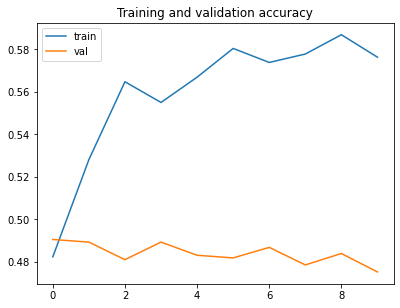

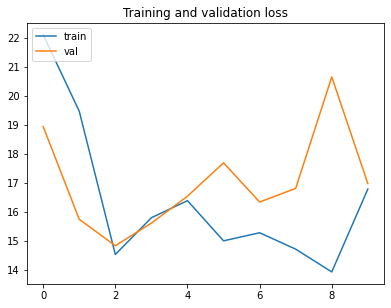

In [42]:
# Retrieve a list of accuracy results on training and test data
# sets for each training epoch
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

# Retrieve a list of list results on training and test data
# sets for each training epoch
loss = history.history['loss']
val_loss = history.history['val_loss']

# Get number of epochs
epochs = range(len(acc))
plt.figure(figsize=(6.4,4.8))
# Plot training and validation accuracy per epoch
plt.plot(epochs, acc)
plt.plot(epochs, val_acc)
plt.title('Training and validation accuracy')
plt.legend(['train', 'val'], loc='upper left')

plt.figure(figsize=(6.4,4.8))

# Plot training and validation loss per epoch
plt.plot(epochs, loss)
plt.plot(epochs, val_loss)
plt.title('Training and validation loss')
plt.legend(['train', 'val'], loc='upper left')

In [21]:
model2 = keras.Sequential([
    keras.layers.Dense(8, input_dim=input_shape, activation=tf.nn.relu), 
    keras.layers.Dense(4, activation=tf.nn.relu), 
    keras.layers.Dense(1, activation=tf.nn.sigmoid)
])

model2.compile(
  optimizer='adam',
  loss='binary_crossentropy',
  metrics=['accuracy'],
)
model2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 8)                 458760    
_________________________________________________________________
dense_2 (Dense)              (None, 4)                 36        
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 5         
Total params: 458,801
Trainable params: 458,801
Non-trainable params: 0
_________________________________________________________________


In [22]:
history = model2.fit(X_train, 
                    y_train, 
                    epochs=20, 
                    batch_size=256,
                    validation_data=(X_val, y_val), 
                    verbose=1)

Train on 6050 samples, validate on 2420 samples
Epoch 1/20
6050/6050 [==============================] - 5s 833us/sample - loss: 7.5636 - accuracy: 0.6795 - val_loss: 6.0222 - val_accuracy: 0.7116
Epoch 2/20
6050/6050 [==============================] - 3s 431us/sample - loss: 2.6087 - accuracy: 0.8597 - val_loss: 4.7209 - val_accuracy: 0.7624
Epoch 3/20
6050/6050 [==============================] - 3s 440us/sample - loss: 1.3281 - accuracy: 0.9076 - val_loss: 4.4463 - val_accuracy: 0.7843
Epoch 4/20
6050/6050 [==============================] - 6s 1ms/sample - loss: 0.7172 - accuracy: 0.9360 - val_loss: 4.3259 - val_accuracy: 0.7946
Epoch 5/20
6050/6050 [==============================] - 3s 441us/sample - loss: 0.5182 - accuracy: 0.9484 - val_loss: 3.9474 - val_accuracy: 0.7988
Epoch 6/20
6050/6050 [==============================] - 3s 452us/sample - loss: 0.3296 - accuracy: 0.9549 - val_loss: 4.2113 - val_accuracy: 0.7992
Epoch 7/20
6050/6050 [==============================] - 3s 434us/s

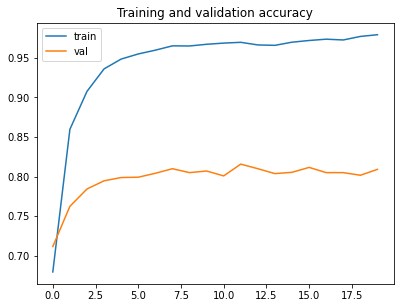

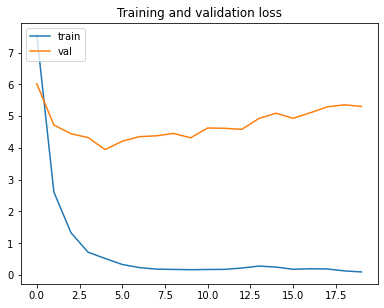

In [23]:
# Retrieve a list of accuracy results on training and test data
# sets for each training epoch
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

# Retrieve a list of list results on training and test data
# sets for each training epoch
loss = history.history['loss']
val_loss = history.history['val_loss']

# Get number of epochs
epochs = range(len(acc))
plt.figure(figsize=(6.4,4.8))
# Plot training and validation accuracy per epoch
plt.plot(epochs, acc)
plt.plot(epochs, val_acc)
plt.title('Training and validation accuracy')
plt.legend(['train', 'val'], loc='upper left')

plt.figure(figsize=(6.4,4.8))

# Plot training and validation loss per epoch
plt.plot(epochs, loss)
plt.plot(epochs, val_loss)
plt.title('Training and validation loss')
plt.legend(['train', 'val'], loc='upper left')